# A simple implementation of genetic algorithms in Python

From [here](https://www.kdnuggets.com/2018/07/genetic-algorithm-implementation-python.html), 

In [1]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline  

## Parametrisation

In [2]:
w = [4,-2,3.5,5,-11,-4.7] 
m = len(w) # number of features
n = 100 # population size
p = 15 # mating poopulation size

## Mutation: rate (probability of mutation at a location) and range (scale of mutation when it happens)
mutation_rate = 0.01
mutation_range = (-0.001,0.001)

n_generations = 500

## weights for the problem

pop_shape = [n,m]
pop_range = (-0.004,0.004)

_Testing_: Parent population size must be sufficiently large. See explanations below

In [3]:
assert p**2 >= n, 'p is too small for this setup, please choose a value of at least %r' % (int(np.ceil(np.sqrt(n))))

## A single iteration, annotated

### Population
We start by sampling our initial "population" of weight vectors, based on the weights and ranges we defined before:

In [4]:
new_population = \
np.random.uniform(
    low =  1.0 * min(pop_range), 
    high = 1.0 * max(pop_range), 
    size = pop_shape
)

We expect to see a uniform distribution of the weights (shown here as a single long vector)

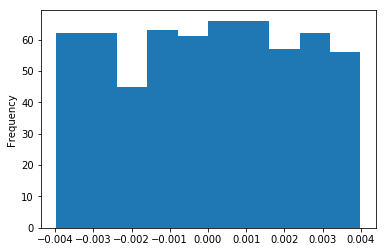

In [5]:
pd.Series(new_population.flatten()).plot(kind = 'hist')

### Fitness 
In order to select the best parents for breeding, we have to introduce the concept of _fitness_. In biology this would be a measure (or measures) of how well do the parents fit their environments. In our case we simply want to choose the parents the perform best against our pre-defined set of weights $w$. 
We want to make sure that fitness is bounded (from both ends) so we use the logistic function:
$$ \text{fitness}(x_i) = logit(x_i^T w) = \frac{1}{1 + exp(- x_i^T w)} $$

In [6]:
def fitness_calc(w, pop):
    return 1 / (1 + np.exp(-1 * np.sum(pop * w, axis = 1)))

And for our initial sample we can calculate the fitness score of each individual

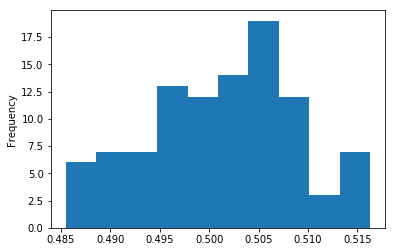

In [7]:
fitness = fitness_calc(w, new_population)
pd.Series(fitness).plot(kind = 'hist')

### Parents
And pick the `p` rows in our current population with the highest fitness for mating (we call them "parents"):

In [8]:
parents = new_population[(-1*fitness).argsort(), :][range(p),:]

We look at all possible pairs (excluding matching a single parent with themselves)

In [9]:
potential_parent_pairs = np.asarray(list(product(range(p),range(p))))

potential_parent_pairs = \
potential_parent_pairs[
    np.apply_along_axis(
        func1d = lambda x: x[0] != x[1],  # only if parents are different
        axis = 1, 
        arr = potential_parent_pairs
    ),
    :
]

We pick "randomly" pick `n-p` pairs of parents (seed is set here for reproducibility). 
_Note:_ We make an assumption here that the number of potential parent pairs $p(p-1)$ is greater or equal to the number of offsprings we need to create to re-populate the next generation (which is $n-p$, assuming we only keep the parents and some of their offsprings) so we are in fact assuming that $p^2 \geq n$ (see the `assert` clause at the beginning of the code)

In [10]:
np.random.seed(seed=12345)
rand_index = np.random.choice(potential_parent_pairs.shape[0], n-p, replace=False) 
parent_pairs_ind = potential_parent_pairs[rand_index,:]

### Mating 
And we pair the selected parents by "splicing" their weights and adding children to the new population

In [11]:
crossover_point = int(np.floor(m/2))
new_population = parents

for i,j in parent_pairs_ind:
    #print('this part', parents[i, 0:crossover_point])
    #print('with this part', parents[j, crossover_point:])
    #print('makes:', np.concatenate((parents[i, 0:crossover_point], parents[j, crossover_point:])))
    new_population = \
    np.vstack((
        new_population, 
        np.concatenate((parents[i, 0:crossover_point], parents[j, crossover_point:]))
    ))

### Mutation
And finally let's introduce some mutation: with probability `mutation_rate` we add a random fluctuation to the weight:

In [12]:
#np.random.seed(seed=12345)
mutation_places = \
np.random.binomial(
    n = 1, 
    p = mutation_rate, 
    size = new_population.shape[0] * new_population.shape[1]
)

mutation_values = \
np.random.uniform(
    high = max(mutation_range), 
    low = min(mutation_range), 
    size = new_population.shape[0] * new_population.shape[1]
)

In [13]:
new_population = new_population + np.reshape(mutation_values * mutation_places, newshape = new_population.shape)

### Re-evaluation
We can now re-evaluate if the new population has better candidates

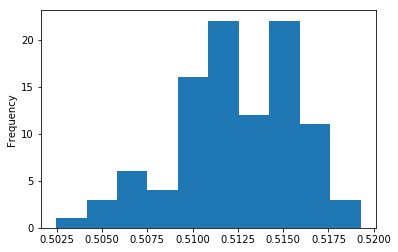

In [14]:
fitness = fitness_calc(w, new_population)
pd.Series(fitness).plot(kind = 'hist')

## Let's iterate!

We can create a simple `for` loop, but since we want to explore different mutation rates we'll wrap it in a function:

In [15]:
def fitness_calc(w, pop):
    return 1 / (1 + np.exp(-1 * np.sum(w * pop, axis = 1)))
    
def genetic_iter(pop, w, mutation_rate = 0.01, n_generations = 20, p  = 20):
    
    ## Collect best relust from each iteration
    fitness_tracking = [np.max(fitness_calc(w, pop))]  
    #print('starting from', fitness_tracking)
    
    for g in range(n_generations):
        fitness = fitness_calc(w, pop) 
        #print(pd.Series(fitness).describe())

        ## Select parents
        parents = pop[(-1*fitness).argsort(), :][range(p),:]
        #print('parents', parents)

        ## Choose parent pairs
        potential_parent_pairs = np.asarray(list(product(range(p),range(p))))

        potential_parent_pairs = \
        potential_parent_pairs[
            np.apply_along_axis(
                func1d = lambda x: x[0] != x[1],  # only if parents are different
                axis = 1, 
                arr = potential_parent_pairs
            ),
            :
        ]

        rand_index = np.random.choice(potential_parent_pairs.shape[0], pop.shape[0]-p, replace=False) 
        parent_pairs_ind = potential_parent_pairs[rand_index,:]

        ## Mate parents
        crossover_point = int(np.floor(pop.shape[1]/2))
        pop = parents

        for i,j in parent_pairs_ind:
            #print('this part', parents[i, 0:crossover_point])
            #print('with this part', parents[j, crossover_point:])
            #print('makes:', np.concatenate((parents[i, 0:crossover_point], parents[j, crossover_point:])))
            pop = \
            np.vstack((
                pop, 
                np.concatenate((parents[i, 0:crossover_point], parents[j, crossover_point:]))
            ))

        ## Mutation
        mutation_places = np.random.binomial(
            n = 1, 
            p = mutation_rate, 
            size = pop.shape[0] * pop.shape[1]
        )

        mutation_values = np.random.uniform(
            high = max(mutation_range)+1, 
            low = min(mutation_range), 
            size = pop.shape[0] * pop.shape[1]
        )

        pop = pop + np.reshape(mutation_values * mutation_places, newshape = pop.shape)
        
        fitness_tracking.append(np.max(fitness_calc(w, pop)))
        
    return fitness_tracking

We reset the population to have a fresh start and run our function:

In [16]:
new_population = np.random.uniform(low=min(pop_range), high=max(pop_range), size=pop_shape)

And explore different rates of mutation

In [17]:
def plot_mutation_rate_progress(mr):
    return pd.Series(
        genetic_iter(
            pop = new_population, 
            w = w, 
            mutation_rate = mr, 
            p = p
        )
    ).plot(kind = 'line')

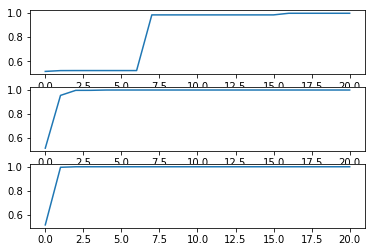

In [18]:
plt.subplot(3,1,1)
plot_mutation_rate_progress(0.001)
plt.subplot(3,1,2)
plot_mutation_rate_progress(0.01)
plt.subplot(3,1,3)
plot_mutation_rate_progress(0.1)

Or the effect of the number of parents

In [19]:
def plot_parent_progress(p):
    return pd.Series(
        genetic_iter(
            pop = new_population, 
            w = w, 
            mutation_rate = 0.01, 
            p = p
        )
    ).plot(kind = 'line')

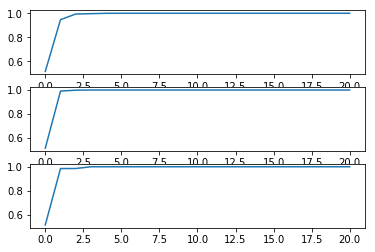

In [20]:
plt.subplot(3,1,1)
plot_parent_progress(10)
plt.subplot(3,1,2)
plot_parent_progress(11)
plt.subplot(3,1,3)
plot_parent_progress(12)

## TODO
* Non /semi random mating mechanism: maybe the best pick the one below them? or choose them with higher probability?  
* Random splicing (sample x% of locations and mix) 